<a href="https://colab.research.google.com/github/R1M1N/ZTM_tf2/blob/main/05_Fine_Tuning_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What are we going to cover
- Introduce fine-tuning transfer learning with TF
- Keras Functional API to build models
- Use small dataset to experiment faster
- Data Augmentation (without adding images, make training set more diverse)
- Running experiments on Food Vision Data
- Introduce model check point call back to save intermediate training results


So we have been writing the walkthrough unzip and couple of other functions again and again in different notebook why not create a [helper_functions.py](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) and make it accessible always.


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-16 15:40:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-16 15:40:41 (99.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [ ]:
# You need to re-download the the helper-functions in every runtime because colab deletes it.

### Let's get some data
We learn how to use tf.keras.application which has bunch of pretrained models https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-10-16 15:40:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.207, 74.125.134.207, 74.125.139.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   173MB/s    in 0.9s    

2023-10-16 15:40:48 (173 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check how many files are there in the folder
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Let's load our data
# Create our training and test directories
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE,
                                                                            label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check class names of our training data
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
train_data_10_percent.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
for images,labels in train_data_10_percent.take(2):
  print(images,labels)

tf.Tensor(
[[[[109.27312   116.27312   108.27312  ]
   [108.1706    115.1706    107.1706   ]
   [108.39493   115.39493   107.39493  ]
   ...
   [ 90.56878   184.54907   232.92166  ]
   [ 97.37657   187.9362    237.65639  ]
   [ 96.924965  185.39838   237.7188   ]]

  [[104.79608   114.9308    103.52663  ]
   [104.51515   115.03954   102.466354 ]
   [101.37691   111.37691   100.37691  ]
   ...
   [ 89.36558   183.54196   231.8165   ]
   [ 89.134415  182.70758   231.1832   ]
   [ 91.22713   190.22623   239.15254  ]]

  [[100.8302    111.8302     95.61591  ]
   [107.10667   118.10667   101.89238  ]
   [104.72991   115.72991    99.515625 ]
   ...
   [ 89.15261   183.38783   229.48589  ]
   [ 86.162964  180.83784   226.54959  ]
   [ 81.43759   184.84813   229.87923  ]]

  ...

  [[190.12315   167.54468    91.51359  ]
   [192.60487   170.62587    94.50487  ]
   [196.87943   175.13       98.97456  ]
   ...
   [175.14142   177.56995   138.99847  ]
   [170.79922   173.22775   135.54373  ]
   [1

In [ ]:
# Let's build a efficientnetB0 model with tf.keras.applications
# 1. BASE MODEL with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so prelearned patterns remain same)
base_model.trainable = False

# 3. Create the inputs into the base model
inputs = tf.keras.layers.Input(shape=(224,224,3), name='Input_Layer')

# 4. If using ResNetv2 you will have to normalize the model
# x = tf.keras.layers.experimental.preprocessing.Normalization()(inputs)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base model (EfficientNet doesnt use normalized data it gets normalized automatically with this model)
x = base_model(inputs)
# Check shape after pass input to base model
print(f"Shape after base model gets inputs {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important features and use reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After Pooling {x.shape}")

# 7 Create an output activation
output = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8. Combine the input and the output layers using tf.keras.Model()
model_0 = tf.keras.Model(inputs,output)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics="accuracy")
# 10. Fit the model
history_model_0 = model_0.fit(train_data_10_percent,
          epochs=5,
          steps_per_epoch=len(train_data_10_percent),
          validation_data=test_data,
          validation_steps=len(test_data),
          callbacks=[create_tensorboard_callback("Tensorflow_hub","Efficient_net_Feature_extraction")])








16705208/16705208 [==============================] - 0s 0us/step
Shape after base model gets inputs (None, 7, 7, 1280)
After Pooling (None, 1280)
Saving TensorBoard log files to: Tensorflow_hub/Efficient_net_Feature_extraction/20231016-154056
Epoch 1/5
24/24 [==============================] - 261s 11s/step - loss: 1.9011 - accuracy: 0.4093 - val_loss: 1.3048 - val_accuracy: 0.7544
Epoch 2/5
24/24 [==============================] - 253s 11s/step - loss: 1.0935 - accuracy: 0.7547 - val_loss: 0.8723 - val_accuracy: 0.8300
Epoch 3/5
24/24 [==============================] - 215s 9s/step - loss: 0.7879 - accuracy: 0.8240 - val_loss: 0.6952 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 252s 11s/step - loss: 0.6382 - accuracy: 0.8627 - val_loss: 0.6104 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 252s 11s/step - loss: 0.5449 - accuracy: 0.8773 - val_loss: 0.5579 - val_accuracy: 0.8608


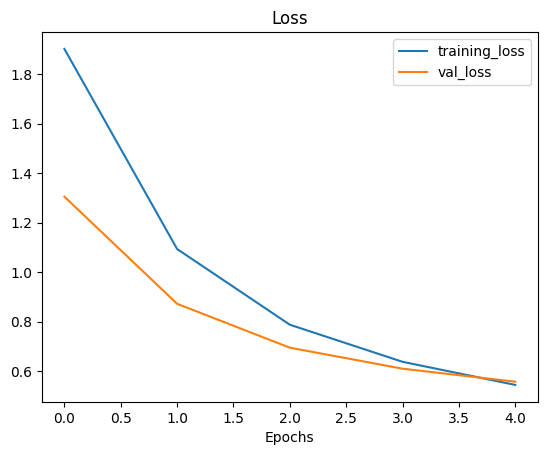

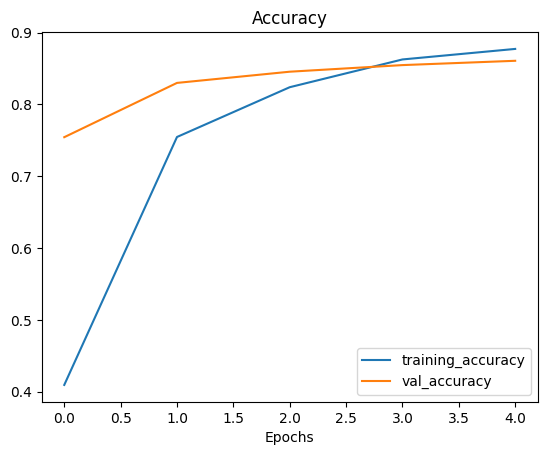

In [ ]:
plot_loss_curves(history_model_0)

In [ ]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

## Getting a feature vector from a trained model

We kinda dont know what going on in our feature vector i.e. GlobalAveragePooling2D() from (None,7,7,1280) what does it do that it gets (None,1280) its like it gets rid of them.
Let's see an example using (1,4,4,3)

In [ ]:
# Define input shape(1,4,4,3)
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
tensor_1 = tf.random.normal(input_shape)
print(f"Random Input Tensor: {tensor_1}\n")

# Passing it to global average pooling layer
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(tensor_1)
print(f"Global Average Pooled Tesor: {global_average_pooling_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {tensor_1.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooling_tensor.shape}")

Random Input Tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

Global Average Pooled Tesor: [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [ ]:
# Let's replicate the global average pooling tensor
tf.reduce_mean(tensor_1,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

In [ ]:
# Let's try with GlobalMaxPooling
# Define input shape(1,4,4,3)
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
tensor_1 = tf.random.normal(input_shape)
print(f"Random Input Tensor: {tensor_1}\n")

# Passing it to global average pooling layer
global_max_pooling_tensor = tf.keras.layers.GlobalMaxPooling2D()(tensor_1)
print(f"Global Max Pooled Tesor: {global_max_pooling_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {tensor_1.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_max_pooling_tensor.shape}")

Random Input Tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

Global Max Pooled Tesor: [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [ ]:
tf.reduce_max(tensor_1,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of transfer learning experiments
1. `model_1`: use feature extraction with 1% of the training data with data augmentation.

2. `model_2` : use feature extraction with 10% of the data with data augmentation.

3. `model_3` : use fine-tuning to with 10% of the training data with data augmentation.

4. `model_4` : use fine-tuning with 100% of the training data with data augmentation.


### The data augmentation done is:
- Random Flip
- Rotation
- Zoom
- Height
- Width

## Creating model_1 with 1% of the training data

In [ ]:
# Let's start fresh and download the 1% data from https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-10-16 16:02:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.207, 142.251.107.207, 74.125.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   125MB/s    in 1.0s    

2023-10-16 16:02:47 (125 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Creating train and test dir
train_dir = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [ ]:
# Walkthrough 1 percent of the data directory and list all the files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

How to do feature extraction Transfer learning
- Unzip Data
- walkthrough
- train test folder split
- data loaders add
- base_model
- inputs
- x =base_model(inputs)
- x(pooling layer)
- output = Dense()(x)
- Create model tf.keras.Model(inputs,output)
- compile model
- fit the data to the model

In [ ]:
train_dir_1_percent = "/content/10_food_classes_1_percent/train/"
test_dir = "/content/10_food_classes_1_percent/test"

In [ ]:
# Data laoders to create batches
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           batch_size=BATCH_SIZE,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Add augmentation layer to directly into our model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomWidth(0.2),
    # keras.preprocessing.Rescaling(1/255.) # Only for ResNetv2
    layers.RandomHeight(0.2)

],name="data_augmentation")

(-0.5, 422.5, 481.5, -0.5)

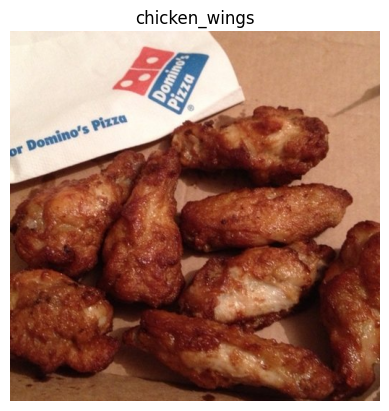

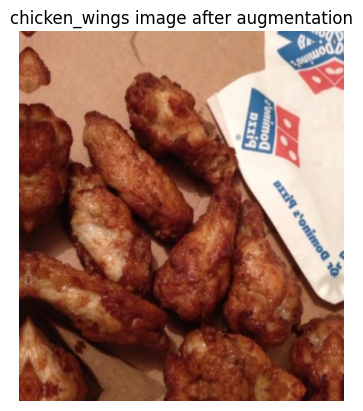

In [ ]:
# Let's see what our data aumentation layer does
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from random import choice

# Let's first choose a random class
random_class =  choice(train_data_1_percent.class_names)
# Let's now select the whole path to our image
random_image = choice(os.listdir("10_food_classes_1_percent/train" + "/" + random_class))

random_image_path = train_dir_1_percent +random_class+"/" +random_image

img = mpimg.imread(random_image_path)

plt.imshow(img)
plt.title(random_class)
plt.axis(False)

# Now let's plot our augmented image

plt.figure()
augmented_img = data_augmentation(img,training=True)
plt.imshow(augmented_img/255.)
plt.title(f"{random_class} image after augmentation")
plt.axis(False)

In [ ]:
# Let's build the model
# First define input shape
input_shape = (224,224,3)

# Now let's choose a base model to build upon and freeze all the layers and include_top is False to set our own output layer
base_model = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Now let's create the input layer
inputs = layers.Input(input_shape,name="Input_layer")

# We do data augmentation on the inputs only so let's do it before passing to the base model
x = data_augmentation(inputs)

# Now let's put the input in our base model
x = base_model(x, training=False)

# Now let's add the pooling layer layer
x = layers.GlobalAveragePooling2D(name="Global_average_pooling_layer")(x)

# Now the output layer
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# Combine the input and output to make a model
model_1 = keras.Model(inputs,outputs)

# Compile the model_1
model_1.compile(loss="categorical_crossentropy",
                metrics="accuracy",
                optimizer="adam")

# Fit the data to the model

history_model_1 = model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=len(test_data)*0.25)



24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/5
3/3 [==============================] - 57s 23s/step - loss: 2.4242 - accuracy: 0.0714 - val_loss: 2.2097 - val_accuracy: 0.1906
Epoch 2/5
3/3 [==============================] - 45s 22s/step - loss: 2.1749 - accuracy: 0.2714 - val_loss: 2.0950 - val_accuracy: 0.2750
Epoch 3/5
3/3 [==============================] - 37s 17s/step - loss: 1.9647 - accuracy: 0.3857 - val_loss: 1.9993 - val_accuracy: 0.3594
Epoch 4/5
3/3 [==============================] - 46s 22s/step - loss: 1.8191 - accuracy: 0.4286 - val_loss: 1.8943 - val_accuracy: 0.4688
Epoch 5/5
3/3 [==============================] - 36s 17s/step - loss: 1.6598 - accuracy: 0.6143 - val_loss: 1.8067 - val_accuracy: 0.5172


In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 123s 2s/step - loss: 1.8421 - accuracy: 0.4848


[1.8420523405075073, 0.4848000109195709]

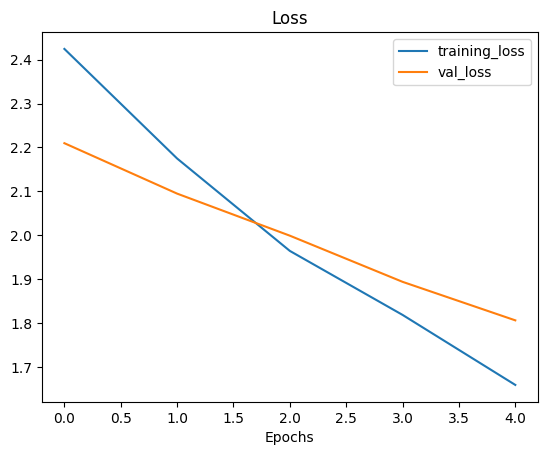

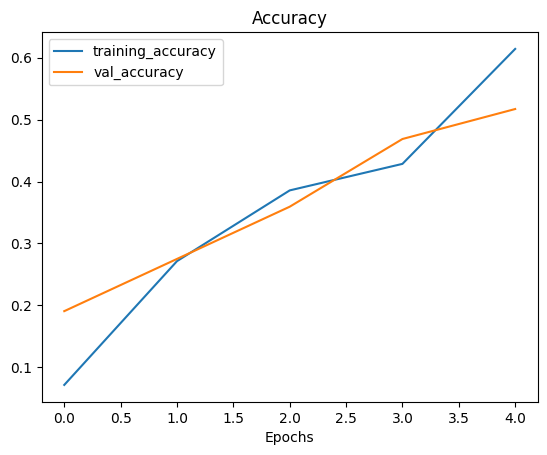

In [ ]:
plot_loss_curves(history_model_1)

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 Global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

## Now Let's create model_2 with 10% of the training data and data augmentation


### We can use the shortcut actually or Completely write the whole process if you are learning you should choose the latter.


In [ ]:
# Downlaod the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-10-16 16:09:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.207, 74.125.134.207, 74.125.139.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   226MB/s    in 0.7s    

2023-10-16 16:09:36 (226 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# Define the train and test directories
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

In [ ]:
# Define data loader and create batches
train_data_10_percent = keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                         image_size=(224,224),
                                                                         label_mode="categorical",
                                                                         )
test_data = keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                             image_size=(224,224),
                                                             label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Now let's create the layer for data augmentation
augmentation_layer = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomRotation(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)

])

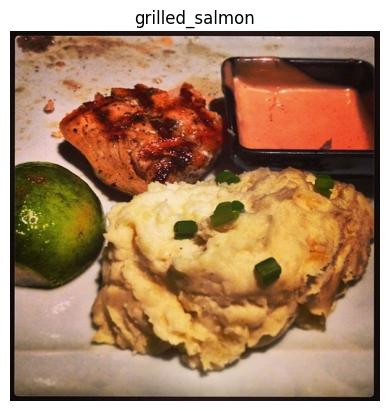

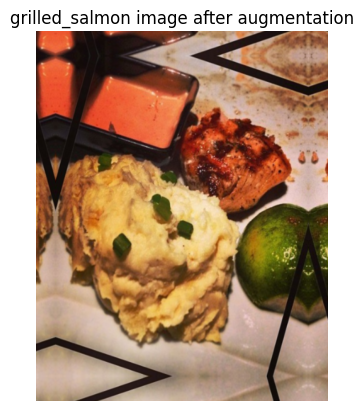

In [ ]:
# Now if you want you can view how it affects an image

target_class = choice(os.listdir("/content/10_food_classes_10_percent/train/"))
target_dir = train_dir + target_class + "/"

target_image = choice(os.listdir(target_dir))
target_image_path = target_dir + target_image

# Read the image
img = mpimg.imread(target_image_path)
plt.imshow(img)
plt.title(target_class)
plt.axis(False)

plt.figure()
plt.title(f"{target_class} image after augmentation")
plt.axis(False)
aug_img = augmentation_layer(img,training=True)
plt.imshow(aug_img/255.)

In [ ]:
# So yeah it works wonderfully now let's put it in the model
# Let's create the model

In [ ]:
# First we make the input layer for that define input_shape
input_shape = (224,224,3)

# Now we create the base model
base_model = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Let's now create the input layer
inputs = layers.Input(input_shape,name="Input_layer")

# Now let's pass it to our augmentation layer before feeding it to the base_model
x = augmentation_layer(inputs)

# Now let's pass this to our base model
x = base_model(x,training=False) # Pass the augmented images in inference mode in this the base model in not trained and batchnorm layers are not updated

# Let's Pool this
x = layers.GlobalAveragePooling2D(name="Global_Average_Pooling_layer")(x)

# Let's pass this through the output_layer
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# combine both the inputs and outputs
model_2 = keras.Model(inputs,outputs)

# let's compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer='adam',
                metrics="accuracy")

# Let's fit the model
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=0.25*len(test_data))


Epoch 1/5
24/24 [==============================] - 106s 4s/step - loss: 2.0354 - accuracy: 0.3360 - val_loss: 1.4701 - val_accuracy: 0.6922
Epoch 2/5
24/24 [==============================] - 86s 4s/step - loss: 1.4370 - accuracy: 0.6213 - val_loss: 1.0729 - val_accuracy: 0.7500
Epoch 3/5
24/24 [==============================] - 86s 4s/step - loss: 1.1096 - accuracy: 0.7187 - val_loss: 0.8704 - val_accuracy: 0.7812
Epoch 4/5
24/24 [==============================] - 89s 4s/step - loss: 0.9595 - accuracy: 0.7493 - val_loss: 0.7723 - val_accuracy: 0.8000
Epoch 5/5
24/24 [==============================] - 87s 4s/step - loss: 0.8473 - accuracy: 0.7933 - val_loss: 0.6740 - val_accuracy: 0.8219


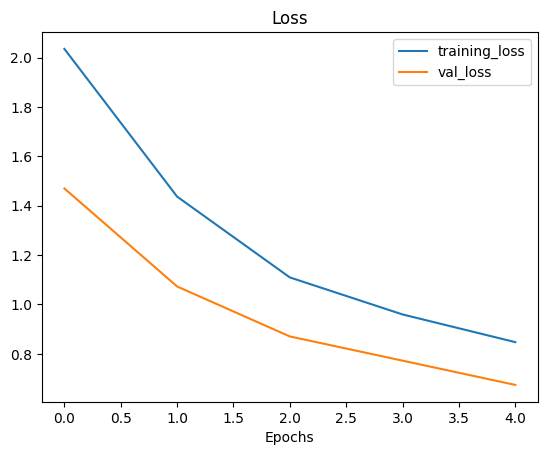

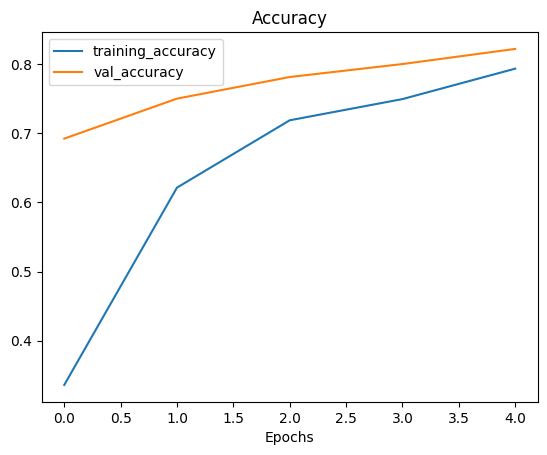

In [ ]:
plot_loss_curves(history_model_2)

In [ ]:
# Now let's create model 3 with fine tuning and 10% of the data